In [14]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('.')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/anc')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install import_ipynb

In [16]:
name = "7th_ELU"

In [17]:
import torchaudio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import librosa
from torch.nn.utils.rnn import pad_sequence
from scipy.signal import fftconvolve
import torch.nn.functional as F

import matplotlib.pyplot as plt
import IPython.display as ipd
import import_ipynb

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [19]:
from model import CRN_2
from dataset import Dataset

In [20]:
sampling_rate = 16000
length = sampling_rate*5

In [21]:
ANC = CRN_2().to(device)

In [22]:
from torch.utils.data import Subset
train_data = Dataset(train=True)
eval_data = Dataset(train=False)

In [23]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
eval_dataloader = DataLoader(eval_data, batch_size=64, shuffle=False)

In [24]:
learning_rate = 1e-3
epochs = 15
optimizer = torch.optim.AdamW(ANC.parameters(),lr = learning_rate)

In [25]:
def rir_batch(wav: torch.Tensor, rir_path: str) -> torch.Tensor:
        rir_np = np.loadtxt(rir_path)[:, 1]
        rir_energy = np.sum(rir_np ** 2)
        rir_np = rir_np / np.sqrt(rir_energy)
        rir_tensor = torch.from_numpy(rir_np).float().to(wav.device)  # (R,)
        rir_tensor = rir_tensor.view(1, 1, -1)  # (1, 1, R) for conv1d
        padding = rir_tensor.size(-1) - 1
        # wav: (B, T) -> (B, 1, T)
        wav = wav.unsqueeze(1)
        # conv1d는 kernel을 뒤집으므로 flip
        rir_tensor_flipped = torch.flip(rir_tensor, dims=[2])
        # F.conv1d는 valid convolution 수행
        y = F.conv1d(wav, rir_tensor_flipped, padding=padding)  # (B, 1, T+R-1)
        y = y.squeeze(1)  # (B, T+R-1)

        return y[:, :length]

In [26]:
import torch.nn.functional as F
epsilon = 1e-8
n_fft = 320
hop_length = 160
win_length = 320
window = torch.hann_window(win_length).to(device)  # STFT/ISTFT에 사용

train_loss = []
train_NMSE = []
eval_loss = []
eval_NMSE = []
epsilon = 1e-8

for epoch in range(epochs):
    print(f"Epoch {epoch}")

    train_loss_epoch = []
    train_nmse_epoch = []
    #--------------------------------------------------------------------------------------------------
    ANC.train()
    for ori, perr in train_dataloader:
        B = ori.size(0)
        ori = ori.to(device)
        perr = perr.to(device)

        optimizer.zero_grad()
        stft_ori = torch.stft(
            ori, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
            return_complex=True, center=True, onesided=True, window=window
        )
        stft_ori_real = stft_ori.real
        stft_ori_imag = stft_ori.imag
        stft_ori_tensor = torch.stack([stft_ori_real, stft_ori_imag], dim=1) # 원하는 사이즈 batch,2,time,320
        stft_pred = ANC(stft_ori_tensor)
        stft_pred_complex = torch.complex(stft_pred[:, 0], stft_pred[:, 1])  # real, imag
        # ISTFT
        istft_pred = torch.istft(
            stft_pred_complex,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            center=True,
            onesided=True,
            window=window,
            length=ori.shape[1]
        )

        u_serr = rir_batch(istft_pred,"s-err.txt")
        error  = perr + u_serr                         # 목표 0
        loss   = torch.mean(error ** 2)
        loss.backward()
        optimizer.step()
    #-------------------------------------------------------------------------------------------------------------
        train_loss_epoch.append(loss.item())
        # 배치별 NMSE 계산 후 저장
        for i in range(B):
            d = u_serr[i]       # 목표=0이므로 target이 곧 분모 신호
            err_i  = error[i]                  # = perr[i] + u_serr[i]

            num   = torch.sum(err_i ** 2)
            denom = torch.sum(d ** 2) + epsilon
            nmse_i = 10 * torch.log10(num / denom)
            train_nmse_epoch.append(nmse_i)

    # 에포크별 평균 기록
    epoch_loss = sum(train_loss_epoch) / len(train_loss_epoch)
    print(f"train_epoch_loss:{epoch_loss}")
    epoch_nmse = torch.mean(torch.stack(train_nmse_epoch)).item()
    print(f"train_epoch_NMSE:{epoch_nmse}")
    train_loss.append(epoch_loss)
    train_NMSE.append(epoch_nmse)
    #-------------------------------------------------------------------------------------------------------------
    eval_loss_epoch = []
    eval_nmse_epoch = []
    #-------------------------------------------------------------------------------------------------------------
    ANC.eval()

    for ori, perr in eval_dataloader:
        B = ori.size(0)                       # 배치 크기
        ori = ori.to(device)
        perr = perr.to(device)
        with torch.no_grad():
            stft_ori = torch.stft(
                ori, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
                return_complex=True, center=True, onesided=True, window=window
            )
            stft_ori_real = stft_ori.real
            stft_ori_imag = stft_ori.imag
            stft_x_tensor = torch.stack([stft_ori_real, stft_ori_imag], dim=1) # 원하는 사이즈 batch,2,time,320
            stft_pred = ANC(stft_x_tensor)
            stft_pred_complex = torch.complex(stft_pred[:, 0], stft_pred[:, 1])  # real, imag
            # ISTFT
            istft_pred = torch.istft(
                stft_pred_complex,
                n_fft=n_fft,
                hop_length=hop_length,
                win_length=win_length,
                center=True,
                onesided=True,
                window=window,
                length=ori.shape[1]
            )
            u_serr = rir_batch(istft_pred,"s-err.txt")
            error  = perr + u_serr                         # 목표 0
            loss   = torch.mean(error ** 2)
    #-------------------------------------------------------------------------------------------------------------
            eval_loss_epoch.append(loss.item())

        # 배치별 NMSE 계산 후 저장
        for i in range(B):
            d = u_serr[i]       # 목표=0이므로 target이 곧 분모 신호
            err_i  = error[i]                  # = perr[i] + u_serr[i]

            num   = torch.sum(err_i ** 2)
            denom = torch.sum(d ** 2) + epsilon
            nmse_i = 10 * torch.log10(num / denom)
            eval_nmse_epoch.append(nmse_i)

    # 에포크별 평균 기록
    epoch_loss = sum(eval_loss_epoch) / len(eval_loss_epoch)
    print(f"eval_epoch_loss:{epoch_loss}")
    epoch_nmse = torch.mean(torch.stack(eval_nmse_epoch)).item()
    print(f"eval_epoch_NMSE:{epoch_nmse}")
    eval_loss.append(epoch_loss)
    eval_NMSE.append(epoch_nmse)

Epoch 0
train_epoch_loss:0.010287125997553418
train_epoch_NMSE:4.139915466308594
eval_epoch_loss:0.008111192068705956
eval_epoch_NMSE:0.7122898697853088
Epoch 1
train_epoch_loss:0.006766486940975476
train_epoch_NMSE:-0.54768306016922
eval_epoch_loss:0.006214483361691237
eval_epoch_NMSE:-1.5250426530838013
Epoch 2
train_epoch_loss:0.005554883457244115
train_epoch_NMSE:-1.9780598878860474
eval_epoch_loss:0.0057535982069869835
eval_epoch_NMSE:-2.014071464538574
Epoch 3
train_epoch_loss:0.005070782574663933
train_epoch_NMSE:-2.583301067352295
eval_epoch_loss:0.005103902394572894
eval_epoch_NMSE:-2.79817271232605
Epoch 4
train_epoch_loss:0.004706221517119417
train_epoch_NMSE:-3.07521915435791
eval_epoch_loss:0.0046921463683247564
eval_epoch_NMSE:-3.4307193756103516
Epoch 5
train_epoch_loss:0.00441122018641099
train_epoch_NMSE:-3.5261282920837402
eval_epoch_loss:0.004491583164781332
eval_epoch_NMSE:-3.721491575241089
Epoch 6
train_epoch_loss:0.004100696771944824
train_epoch_NMSE:-4.042741775

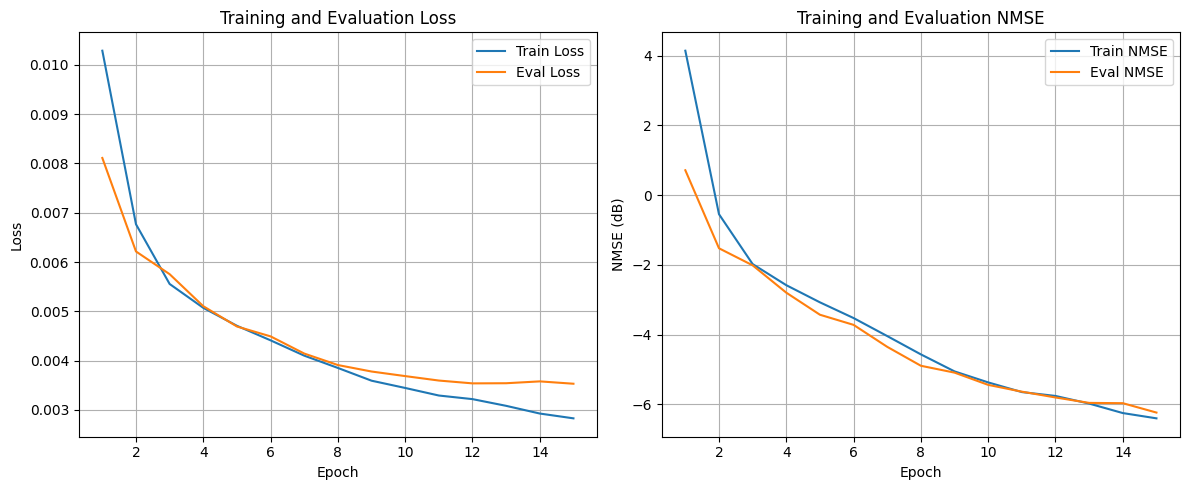

In [27]:
import matplotlib.pyplot as plt


epochs = list(range(1, len(train_loss) + 1))

# 그래프 출력
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, eval_loss, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)

# NMSE 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_NMSE, label='Train NMSE')
plt.plot(epochs, eval_NMSE, label='Eval NMSE')
plt.xlabel('Epoch')
plt.ylabel('NMSE (dB)')
plt.title('Training and Evaluation NMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{name}.png", dpi=300)
plt.show()

In [28]:
torch.save(ANC.state_dict(), f'{name}.pth')